# Test learning capacity
In this notebook we will test whether the generator structure can actually learn. Use a simple example from Pytorch.
See [source](https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe).


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import math
import threading
import logging
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

import matplotlib.pyplot as plt
from os import system

In [2]:
dims = 4
samples = 250
addit = 4
X1 = torch.randn(samples, dims)
X2 = torch.randn(samples, dims) + addit
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(samples, 1)
Y2 = torch.ones(samples, 1)
Y = torch.cat([Y1, Y2], dim=0)

print(X.size())
print(Y.size())

torch.Size([500, 4])
torch.Size([500, 1])


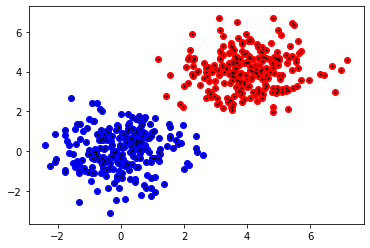

In [3]:

plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='r')
plt.scatter(X[:, 0], X[:, 1], color='k', s=1);

In [ ]:
Here the contents of the different classes are displayed:

In [4]:
class FTT_Layer(torch.nn.Module):
    def __init__(self, N, rank, imwidth, imheight, verbose = 0):
        super(FTT_Layer, self).__init__()

        # N = order of the polynomial = order of the tensor A:
        # A is of dimension (s, s, ..., s) = (N x s)
        # rank = rank used for the tensor cores
        # size = length of the flattened input
        self.N = N
        self.rank = rank
        self.s = imwidth * imheight
        self.verbose = verbose

        # Make a list of TTcore ranks, starting from r_0 = r_N = 1: perhaps feed it in as a list? isinstance(rank, list)
        self.ranklist = [1, 1]
        for n in range(self.N - 1):
            self.ranklist.insert(-1, self.rank)

        # Start by making the tensor train: store the matrices in one big parameterlist
        self.TT = torch.nn.ParameterList()

        # Make s instances for every mode of the tensor, or make a 3D tensor instead:
        for n in range(self.N):
            # Make tensors of size (r_{k-1}, n_{k} = self.s, r_{k})
            TTcore = torch.empty(self.ranklist[n], self.s, self.ranklist[n+1])
            torch.nn.init.xavier_normal_(TTcore)
            #torch.nn.init.xavier_uniform_(TTcore)
            TTcore /= self.s
            self.TT.append(torch.nn.Parameter(TTcore))

    def forward(self, z):
        self.z = z.clone()

        f = self.TT[0][0]
        for k in range(1, self.N):
            d1, d2 = self.ranklist[k], self.ranklist[k+1]
            
            extra = torch.matmul(self.z, self.TT[k].permute(1,0,2).reshape(self.s, d1*d2))
            extra = extra.reshape(d1, d2)
            f = torch.matmul(f, extra)
            
        out = f.reshape(-1)
        return out


In [5]:
class PolyNet(torch.nn.Module):
    def __init__(self, layer, N, rank, imwidth, imheight):
        super(PolyNet, self).__init__()

        self.c = 1
        self.imwidth, self.imheight = imwidth, imheight
        self.s = imwidth*imheight
        self.PolyLayer = layer(N, rank, imwidth, imheight, 0)
        self.BN = nn.BatchNorm2d(num_features=1)
        
    def forward(self, x):
        # Register dimensions:
        xshape = x.shape
        if len(xshape) == 2:
            self.batch_size = 1
        elif len(xshape) == 4:
            self.batch_size = xshape[0]
        else:
            raise ValueError 
            
        # Register x as attribute for parallel access, and clone because dataset would be overwritten
        self.x = self.BN(x.clone())
        self.x = self.x.reshape(self.batch_size, self.c, self.s) # flatten to the 1D equivalent vector
        
        for batch in range(self.batch_size):
            self.x[batch, self.c-1, :] = self.PolyLayer(self.x[batch, self.c-1, :])
        
        self.x = self.x.reshape(self.batch_size, -1)
        self.x = self.x.sum(1)
        
        return self.x


In [6]:
import SequentialGenerator as g

In [7]:
# Make the 'generator' network: in this case to be used as a feed forward network
batch_size = 100
N = 10
rank = 30
imwidth, imheight = int(dims/2), int(dims/2)

#net = PolyNet(FTT_Layer, N, rank, imwidth, imheight)
net = g.Generator(g.FTT_Layer, N, rank, imwidth, imheight)

opt = torch.optim.Adam(net.parameters(), lr=0.005)

criterion = nn.BCELoss()


In [8]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    epochloss = 0
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
        y_batch = Y[beg_i:beg_i + batch_size, :]

        #x_batch = Variable(x_batch, requires_grad=True)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # Reformat output of the network when using the .py file (output is not formatted for binary classification:
        y_hat = y_hat.reshape(batch_size, -1)
        y_hat = y_hat.sum(1)
        y_hat = torch.sigmoid(y_hat)
        y_batch = y_batch[:, 0]
        
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        epochloss += loss.detach().numpy()
        losses.append(loss.detach().numpy())
    return epochloss

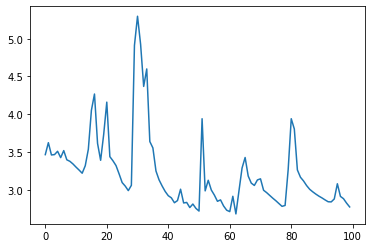

In [9]:
e_losses = []
num_epochs = 100
for e in range(num_epochs):
    print("epoch", e+1, end='\r')
    e_losses.append(train_epoch(net, opt, criterion, batch_size))

plt.plot(e_losses);

system('say complete');

Accuracy score:  94.0


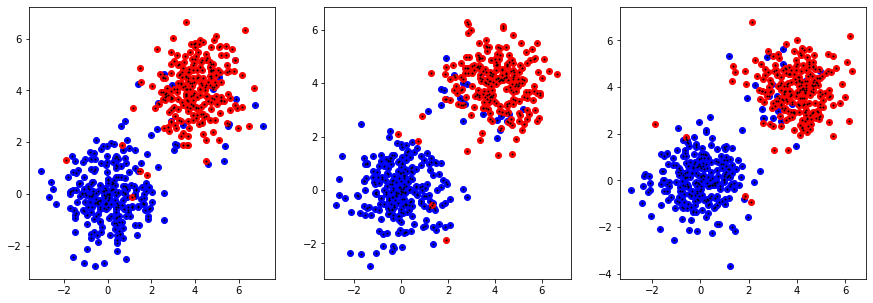

In [10]:
# Test it out
X_1 = torch.randn(samples, dims)
X_2 = torch.randn(samples, dims) + addit
X_t = torch.cat([X_1, X_2], dim=0)

Y1 = torch.zeros(samples)
Y2 = torch.ones(samples)
true = torch.cat([Y1, Y2], dim=0)


net.eval()
results = torch.zeros(X_t.shape[0])
for beg_i in range(0, X_t.size(0), batch_size):
    x_batch = X_t[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
    results[beg_i:beg_i + batch_size] = net(x_batch).reshape(batch_size, -1).sum(1)

results = torch.round(torch.sigmoid(results))

X1_t = torch.where(results == 0)[0]
X2_t = torch.where(results == 1)[0]

correct_results_sum = (results == true).sum().float()
acc = correct_results_sum/true.shape[0]
acc = torch.round(acc * 100)
print("Accuracy score: ", acc.item())

Xd = X_t.detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].scatter(Xd[X1_t, 0], Xd[X1_t, 1], color='b')
ax[0].scatter(Xd[X2_t, 0], Xd[X2_t, 1], color='r')
ax[0].scatter(Xd[:, 0], Xd[:, 1], color='k', s=1)

ax[1].scatter(Xd[X1_t, 1], Xd[X1_t, 2], color='b')
ax[1].scatter(Xd[X2_t, 1], Xd[X2_t, 2], color='r')
ax[1].scatter(Xd[:, 1], Xd[:, 2], color='k', s=1)

ax[2].scatter(Xd[X1_t, 2], Xd[X1_t, 3], color='b')
ax[2].scatter(Xd[X2_t, 2], Xd[X2_t, 3], color='r')
ax[2].scatter(Xd[:, 2], Xd[:, 3], color='k', s=1);



# Can we do better?
Perform a grid search:


In [11]:

learning_rates = torch.logspace(-3, 0, 10)
batch_sizes = [50, 100, 250]
Ns = [i for i in range(3, 10)]
ranks = [2*i for i in range(2, 10)]

bestvals = {'N':0, 'rank':0, 'lr':0, 'BestLoss':100} 

for N in Ns:
    # safety pin: 
    break
    print("N =", N, end ='\r')
    for rank in ranks:
        print("rank =", rank, end ='\r')
        for learning_rate in learning_rates:
            print("learning_rate =", learning_rate.item(), end ='\r')

            net = PolyNet(FTT_Layer, N, rank, imwidth, imheight)
            opt = torch.optim.Adam(net.parameters(), lr=learning_rate.item())

            #train:
            e_losses = []
            num_epochs = 50
            for e in range(num_epochs):
                print('{0: <6}'.format('N = ' + str(N).zfill(2)), '{0: <6}'.format('rank = ' + str(rank).zfill(2)), '{0:25}'.format('learning_rate = ' + str(round(learning_rate.item(), 5))), '{0: <7}'.format('epoch = ' + str(e+1).zfill(2)), end='\r')
                #print("epoch", e+1, end='\r')
                try:
                    epoch = train_epoch(net, opt, criterion, batch_size)
                    e_losses.append(train_epoch(net, opt, criterion, batch_size))
                except KeyboardInterrupt:
                    raise
                except:
                    print("\n Epoch", e, "failed")
                    
            # Extract best losses:
            mid = int(num_epochs/2)
            if sum(e_losses[0:mid])/len(e_losses[0:mid]) < sum(e_losses[mid:-1])/len(e_losses[mid:-1]):
                # Then the loss did not decrease
                continue
            if e_losses[-1] < bestvals['BestLoss']:
                print("\n Found a loss of", e_losses[-1])
                bestvals['N'] = N
                bestvals['rank'] = rank
                bestvals['lr'] = learning_rate
                bestvals['BestLoss'] = e_losses[-1]

system('say grid search complete');
